In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, confusion_matrix, precision_recall_curve,
    average_precision_score, roc_curve
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Load and Preprocess Datasets
# -------------------------------

# Set paths (adjust if needed)
kaggle_path = "/Users/ganeshreddy/Desktop/Online_Banking_fraud_Detection/creditcard.csv"
neurips_dir = "/Users/ganeshreddy/Desktop/Online_Banking_fraud_Detection/NeurIPS Bank Account Fraud"

# Load Kaggle dataset
df_kaggle = pd.read_csv(kaggle_path)
scaler = StandardScaler()
df_kaggle['Amount'] = scaler.fit_transform(df_kaggle[['Amount']])
df_kaggle['Time'] = scaler.fit_transform(df_kaggle[['Time']])
X_kaggle = df_kaggle.drop(columns=['Class']).values
y_kaggle = df_kaggle['Class'].values

# Load NeurIPS datasets
neurips_files = glob.glob(os.path.join(neurips_dir, "*.csv"))
frames = []

for file in neurips_files:
    df = pd.read_csv(file)
    fraud_col = next((col for col in df.columns if col.lower() in ['fraud', 'fraud_bool', 'is_fraud']), None)
    if not fraud_col:
        continue
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=[fraud_col]).columns
    df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])
    frames.append(df)

# Merge NeurIPS
if frames:
    df_neurips = pd.concat(frames, ignore_index=True)
    fraud_col = next((col for col in df_neurips.columns if col.lower() in ['fraud', 'fraud_bool', 'is_fraud']), None)
    X_neurips = df_neurips.drop(columns=[fraud_col]).values
    y_neurips = df_neurips[fraud_col].values
else:
    X_neurips, y_neurips = np.array([]), np.array([])

2025-05-23 11:57:20.957076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -------------------------------
# 2. Align Datasets by Feature Count Automatically
# -------------------------------
df_kaggle_X = pd.DataFrame(X_kaggle)
df_neurips_X = pd.DataFrame(X_neurips)

min_cols = min(df_kaggle_X.shape[1], df_neurips_X.shape[1])
df_kaggle_X_aligned = df_kaggle_X.iloc[:, :min_cols]
df_neurips_X_aligned = df_neurips_X.iloc[:, :min_cols]

X_all = np.vstack([df_kaggle_X_aligned.values, df_neurips_X_aligned.values])
y_all = np.concatenate([y_kaggle, y_neurips])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, stratify=y_all, random_state=42)

# -------------------------------
# 3. Autoencoder Model
# -------------------------------
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    bottleneck = Dense(4, activation='relu')(encoded)
    decoded = Dense(8, activation='relu')(bottleneck)
    decoded = Dense(16, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

autoencoder = build_autoencoder(X_train.shape[1])
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
61867/61867 [==============================] - 92s 1ms/step - loss: 0.6371 - val_loss: 0.6034
Epoch 2/10
61867/61867 [==============================] - 86s 1ms/step - loss: 0.5970 - val_loss: 0.5944
Epoch 3/10
61867/61867 [==============================] - 83s 1ms/step - loss: 0.5838 - val_loss: 0.5783
Epoch 4/10
61867/61867 [==============================] - 85s 1ms/step - loss: 0.5766 - val_loss: 0.5764
Epoch 5/10
61867/61867 [==============================] - 87s 1ms/step - loss: 0.5755 - val_loss: 0.5746
Epoch 6/10
61867/61867 [==============================] - 86s 1ms/step - loss: 0.5681 - val_loss: 0.5618
Epoch 7/10
61867/61867 [==============================] - 83s 1ms/step - loss: 0.5526 - val_loss: 0.5516
Epoch 8/10
61867/61867 [==============================] - 85s 1ms/step - loss: 0.5504 - val_loss: 0.5479
Epoch 9/10
61867/61867 [==============================] - 85s 1ms/step - loss: 0.5443 - val_loss: 0.5437
Epoch 10/10
61867/61867 [==============================

In [3]:
# -------------------------------
# 4. Evaluation
# -------------------------------
reconstructions = autoencoder.predict(X_test)
mse = np.mean((X_test - reconstructions)**2, axis=1)
threshold = np.percentile(mse, 98)
preds = (mse > threshold).astype(int)

# Metrics
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
roc_auc = roc_auc_score(y_test, mse)
pr_auc = average_precision_score(y_test, mse)

print("\n📊 Centralized Autoencoder Metrics:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"PR AUC:    {pr_auc:.4f}")

58921/58921 [==============================] - 52s 878us/step

📊 Centralized Autoencoder Metrics:
TP: 714, FP: 36995, TN: 1828447, FN: 19287
Accuracy: 0.9701
Precision: 0.0189
Recall:    0.0357
F1 Score:  0.0247
ROC AUC:   0.5054
PR AUC:    0.0124


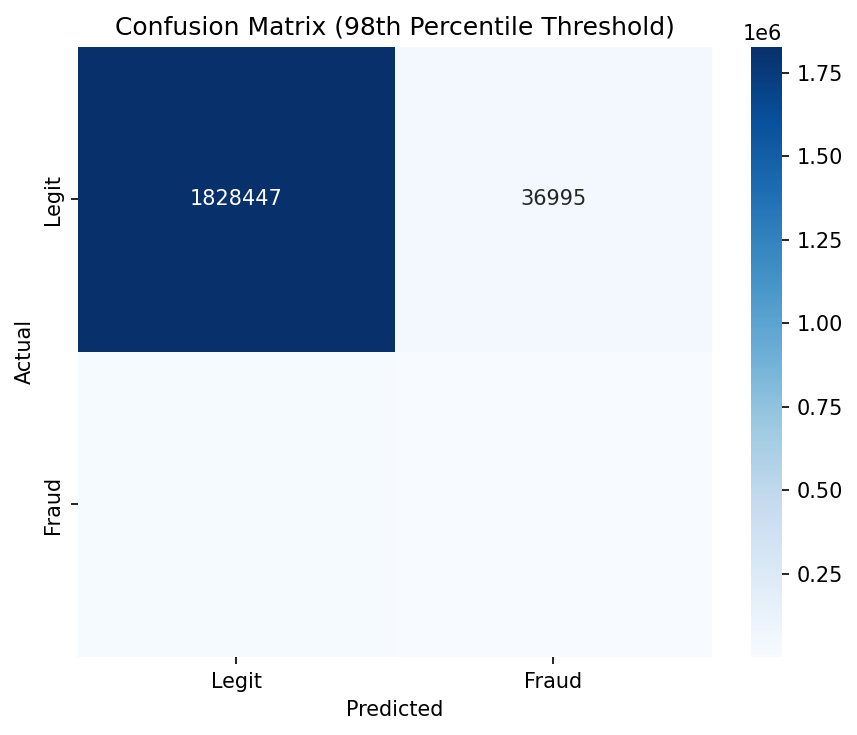

In [22]:
# -------------------------------
# 5. Visualization
# -------------------------------
# Confusion matrix
plt.figure(figsize=(6, 5), dpi=150)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix (98th Percentile Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

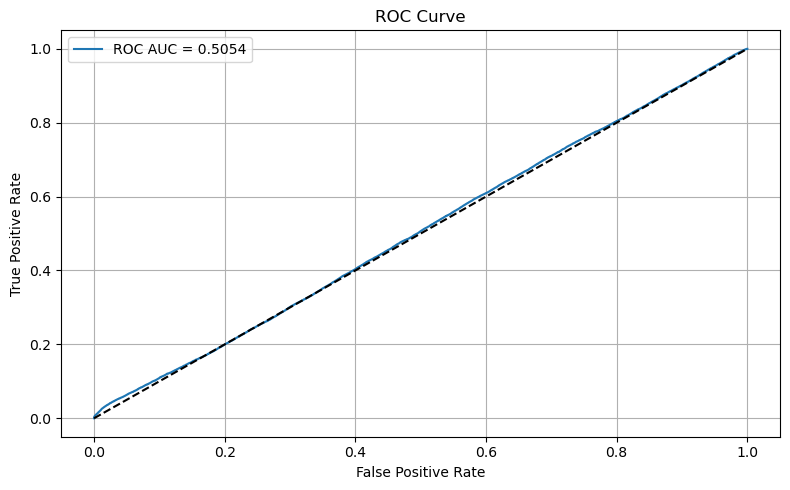

In [24]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, mse)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

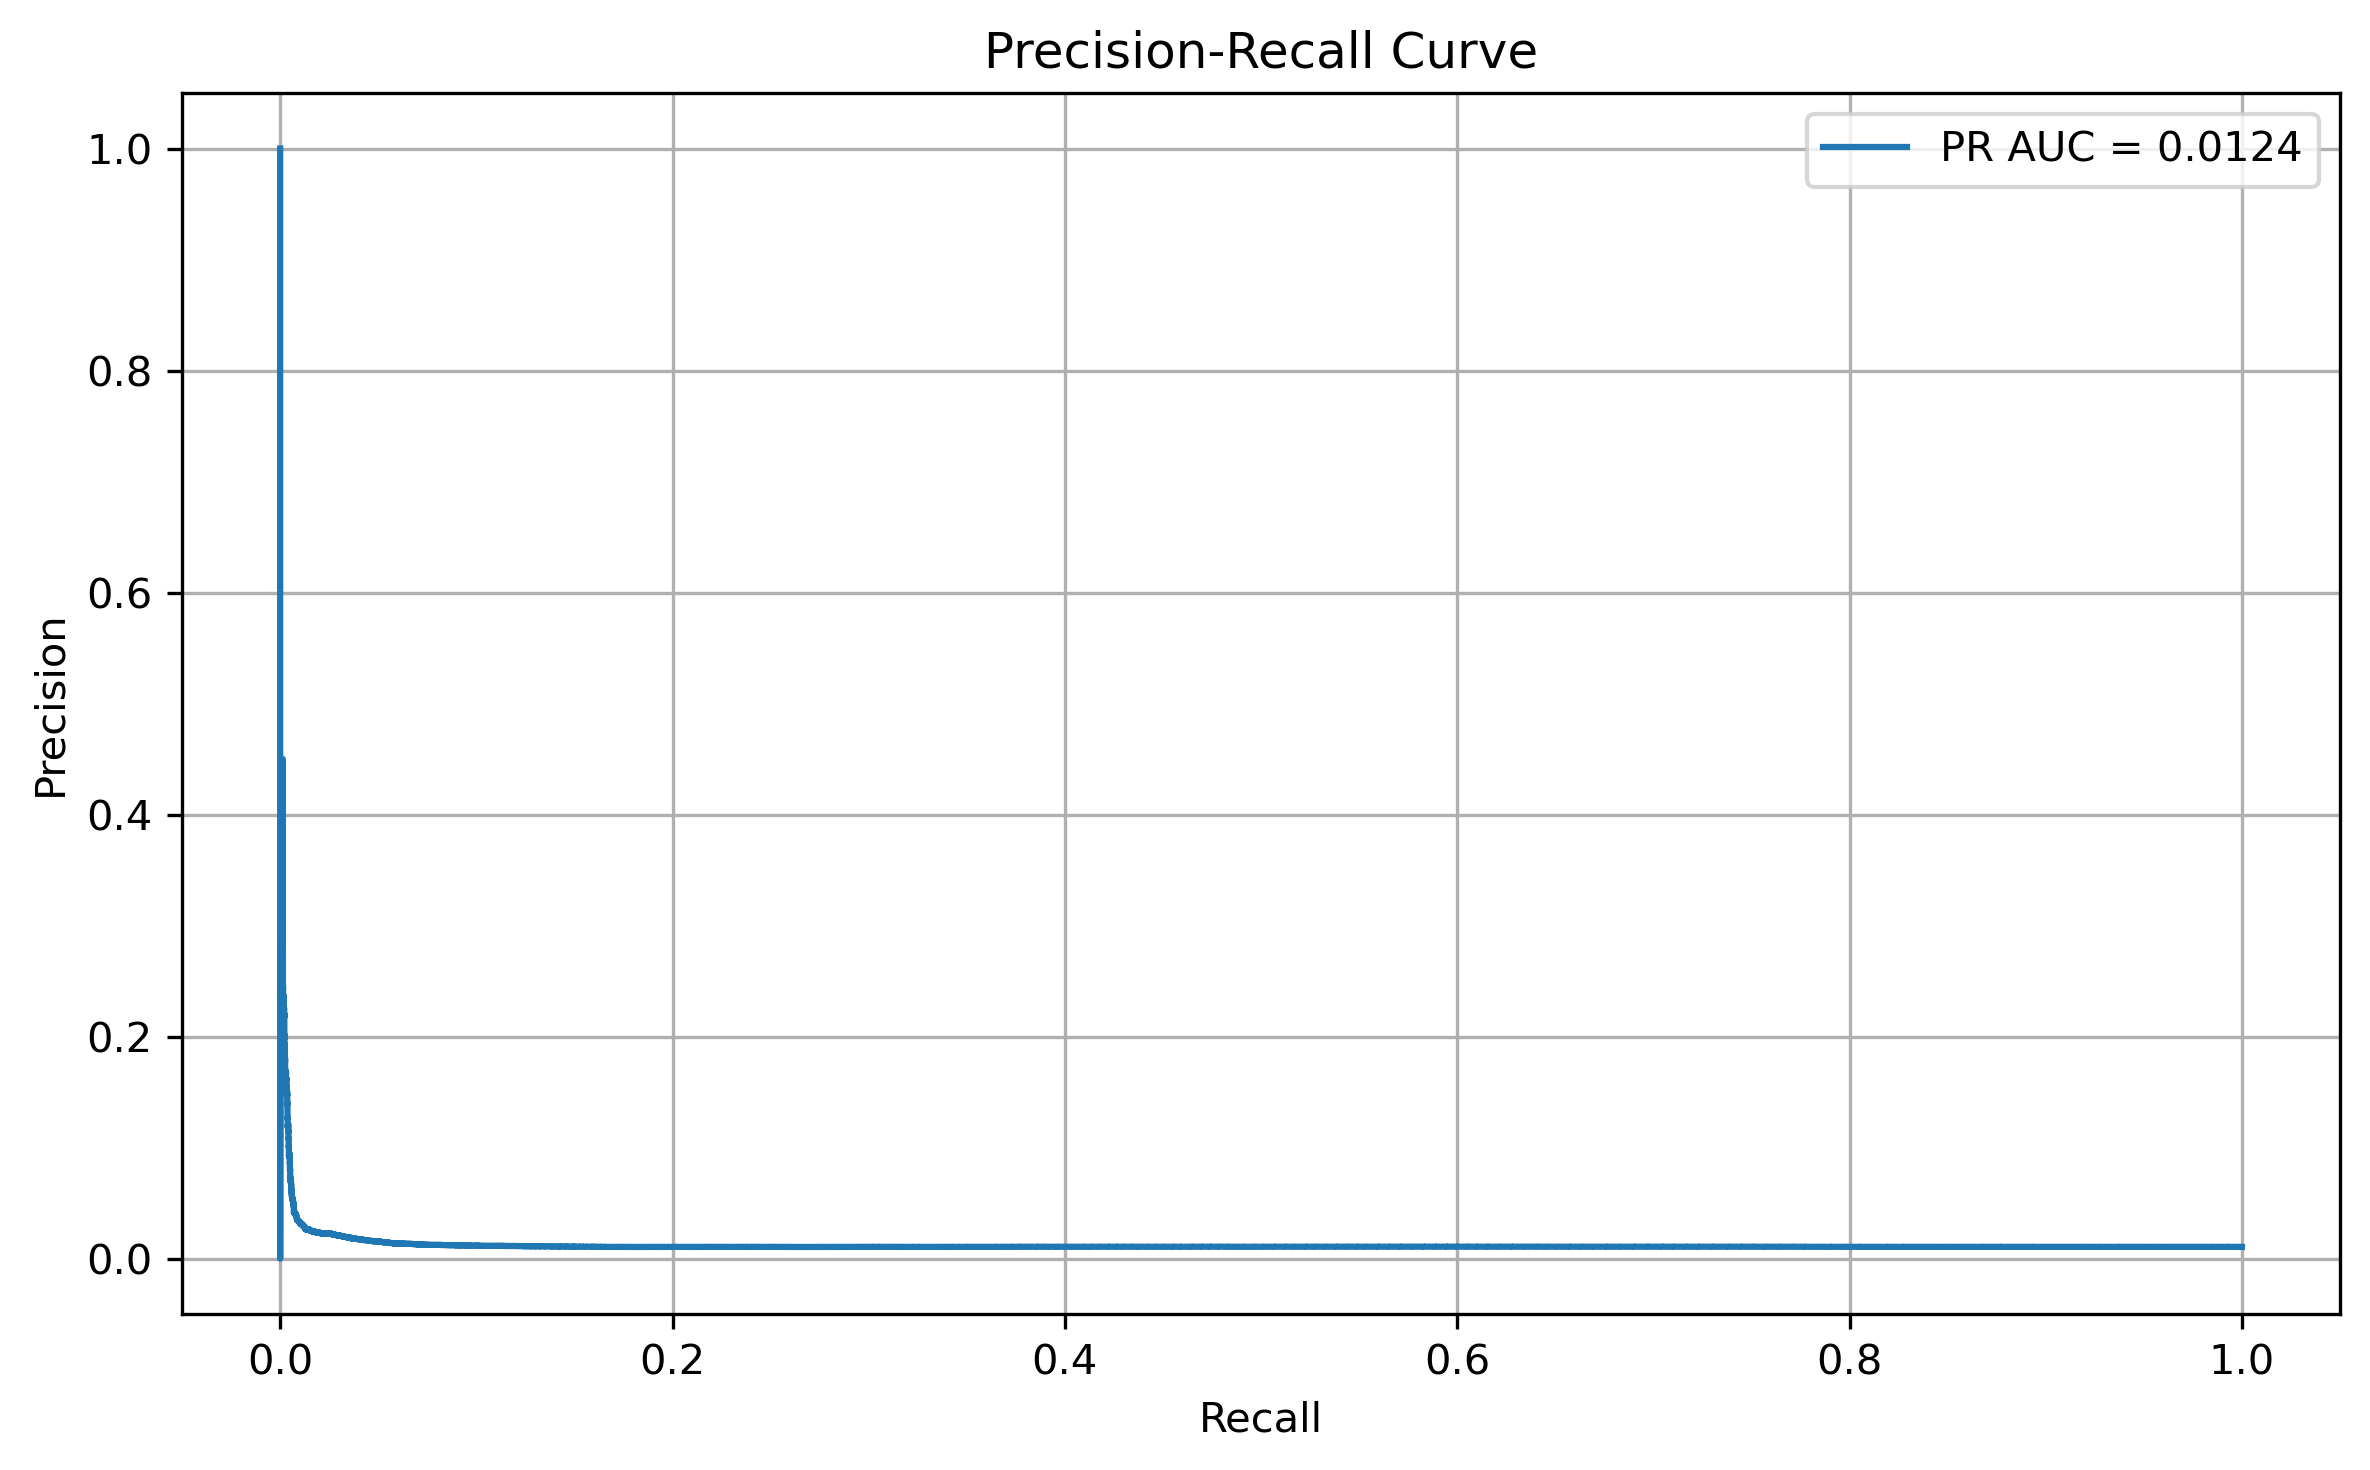

In [12]:
# PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, mse)
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(recall_vals, precision_vals, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

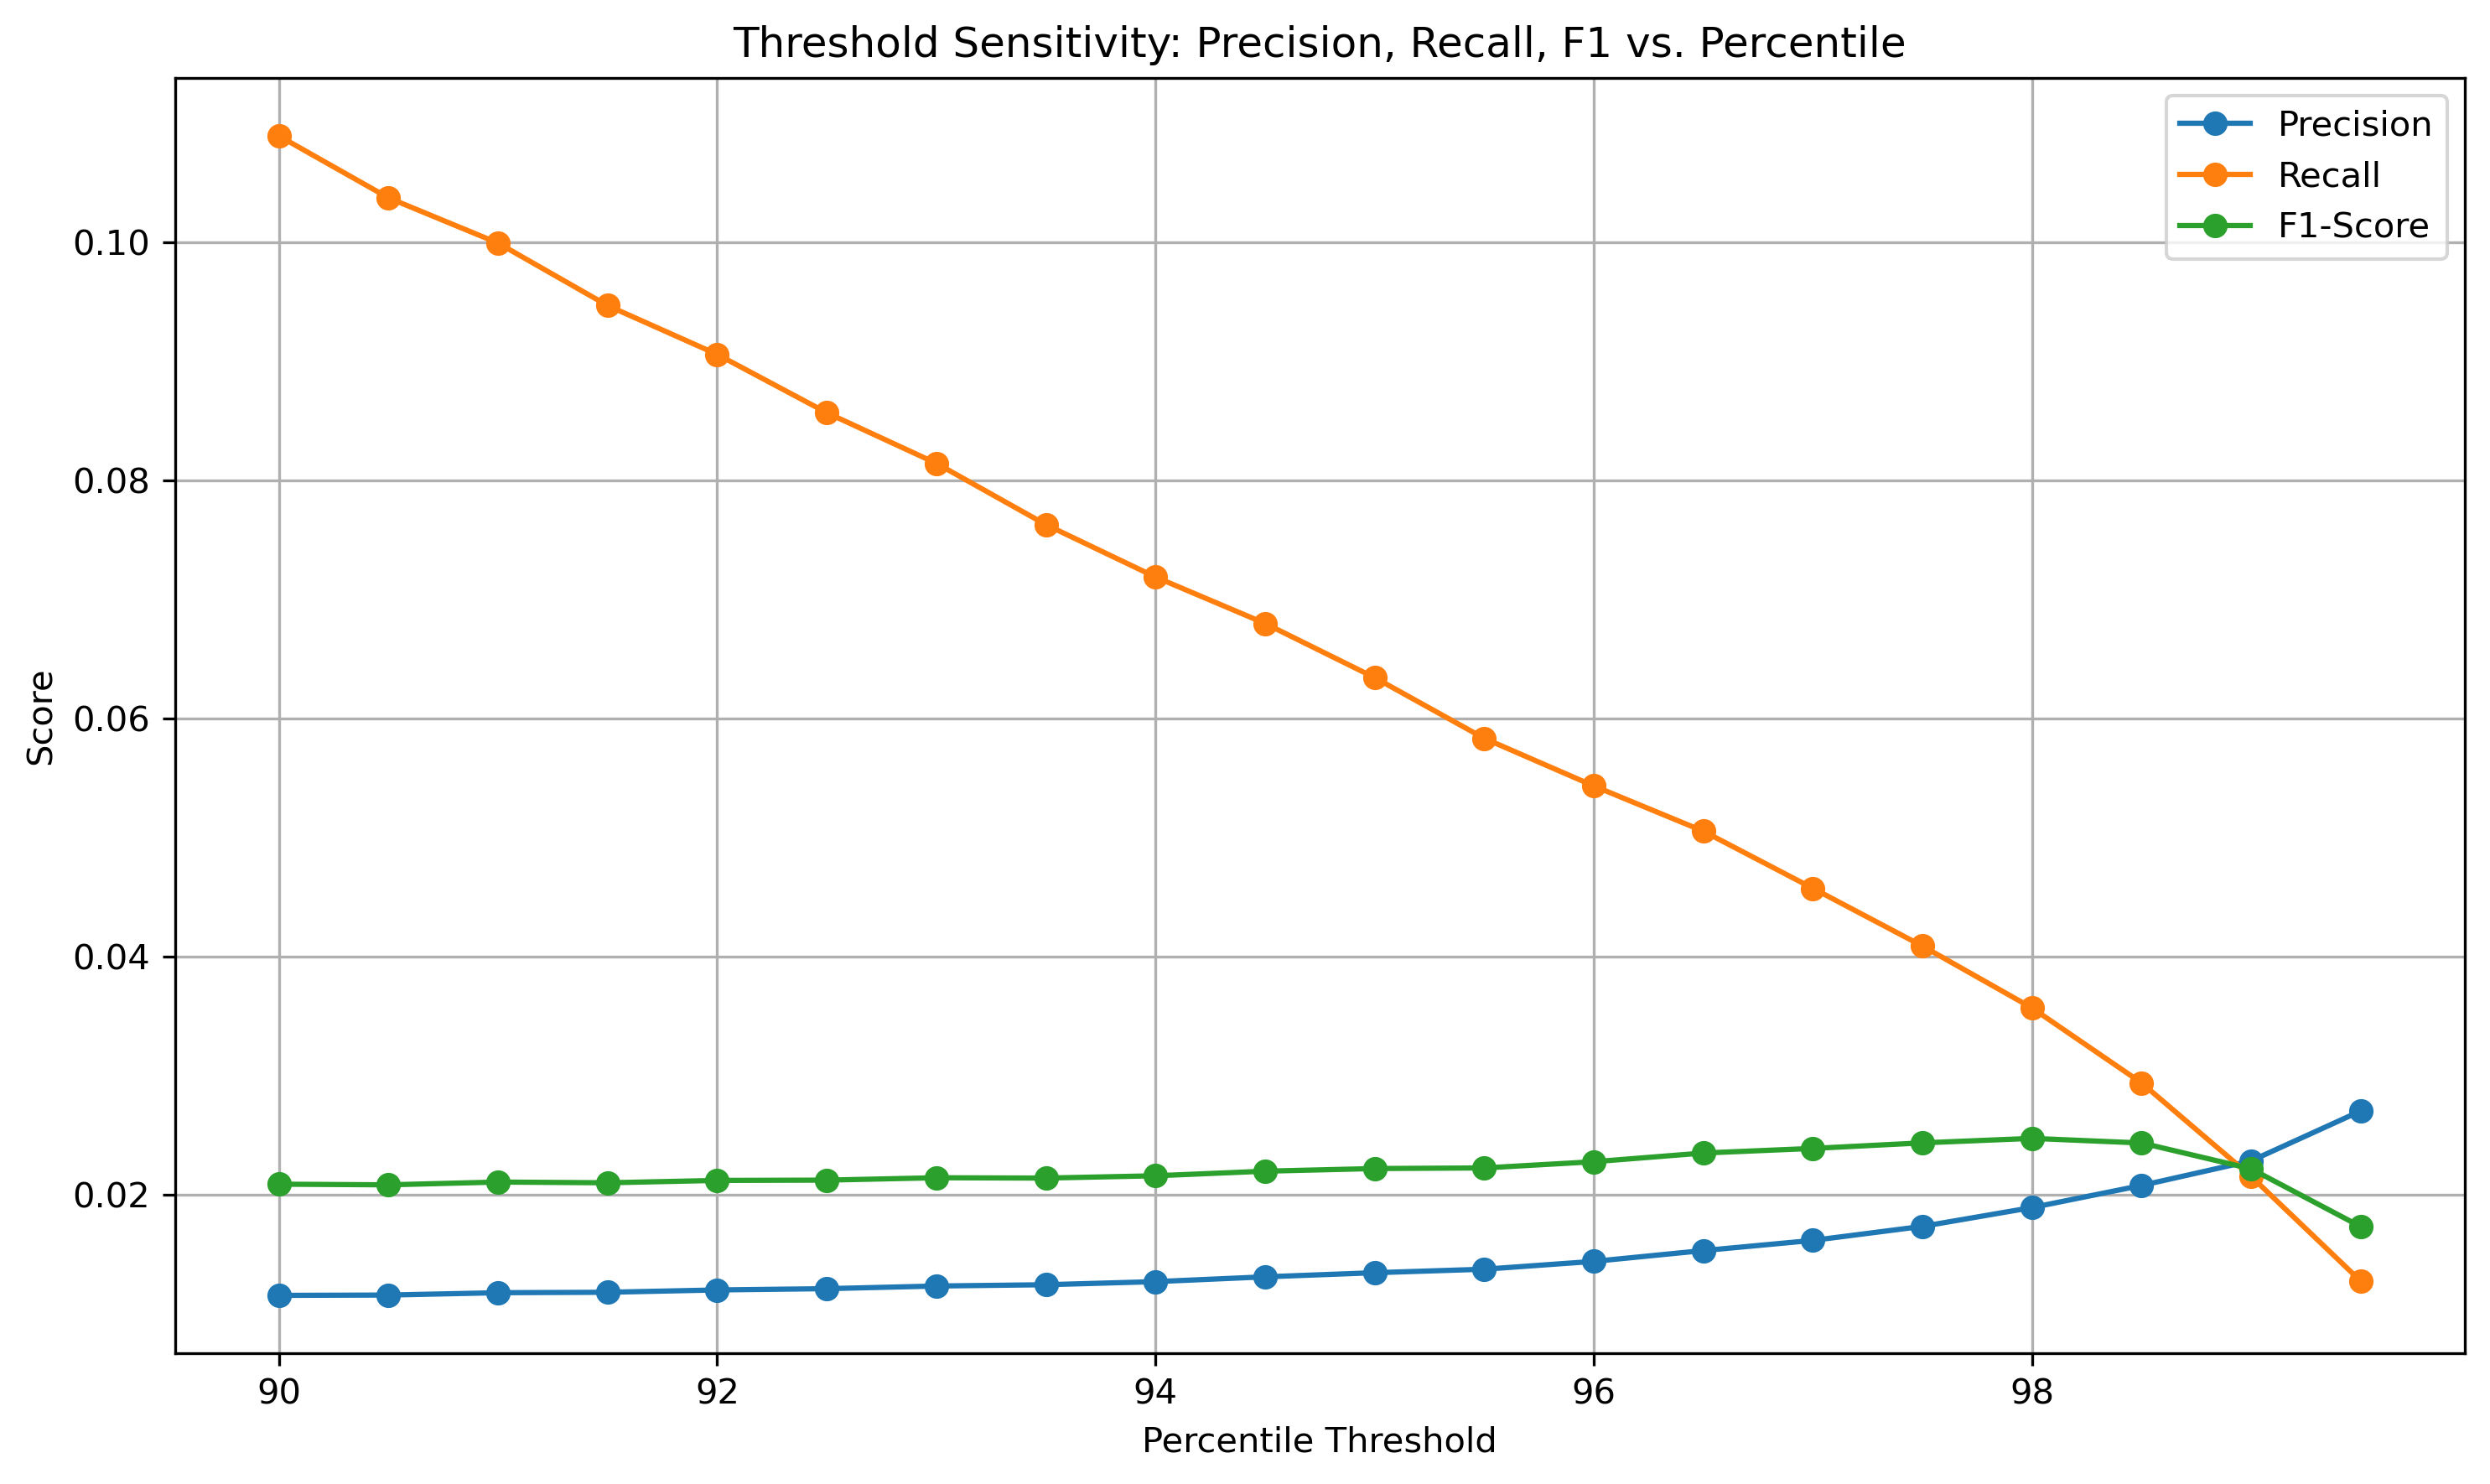

In [11]:
# -------------------------------
# 6. Threshold Sensitivity
# -------------------------------
percentiles = np.arange(90, 99.91, 0.5)
precision_list, recall_list, f1_list = [], [], []

for p in percentiles:
    t = np.percentile(mse, p)
    preds_t = (mse > t).astype(int)
    if len(np.unique(preds_t)) > 1:
        precision_list.append(precision_score(y_test, preds_t))
        recall_list.append(recall_score(y_test, preds_t))
        f1_list.append(f1_score(y_test, preds_t))
    else:
        precision_list.append(np.nan)
        recall_list.append(np.nan)
        f1_list.append(np.nan)

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(percentiles, precision_list, label='Precision', marker='o')
plt.plot(percentiles, recall_list, label='Recall', marker='o')
plt.plot(percentiles, f1_list, label='F1-Score', marker='o')
plt.title("Threshold Sensitivity: Precision, Recall, F1 vs. Percentile")
plt.xlabel("Percentile Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# -------------------------------
# Threshold Sensitivity Analysis (Key Checkpoints)
# -------------------------------
print("\n🔍 Threshold Sensitivity Analysis")
for p in [95, 98, 99]:
    thresh = np.percentile(mse, p)
    preds_thresh = (mse > thresh).astype(int)

    if len(np.unique(preds_thresh)) > 1:
        precision = precision_score(y_test, preds_thresh)
        recall = recall_score(y_test, preds_thresh)
        f1 = f1_score(y_test, preds_thresh)
        print(f"{p}th Percentile Threshold = {thresh:.5f} --> Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    else:
        print(f"{p}th Percentile Threshold = {thresh:.5f} --> No valid classification (only one class predicted)")



🔍 Threshold Sensitivity Analysis
95th Percentile Threshold = 0.96831 --> Precision: 0.0135, Recall: 0.0634, F1: 0.0222
98th Percentile Threshold = 1.20546 --> Precision: 0.0189, Recall: 0.0357, F1: 0.0247
99th Percentile Threshold = 1.45840 --> Precision: 0.0229, Recall: 0.0215, F1: 0.0222


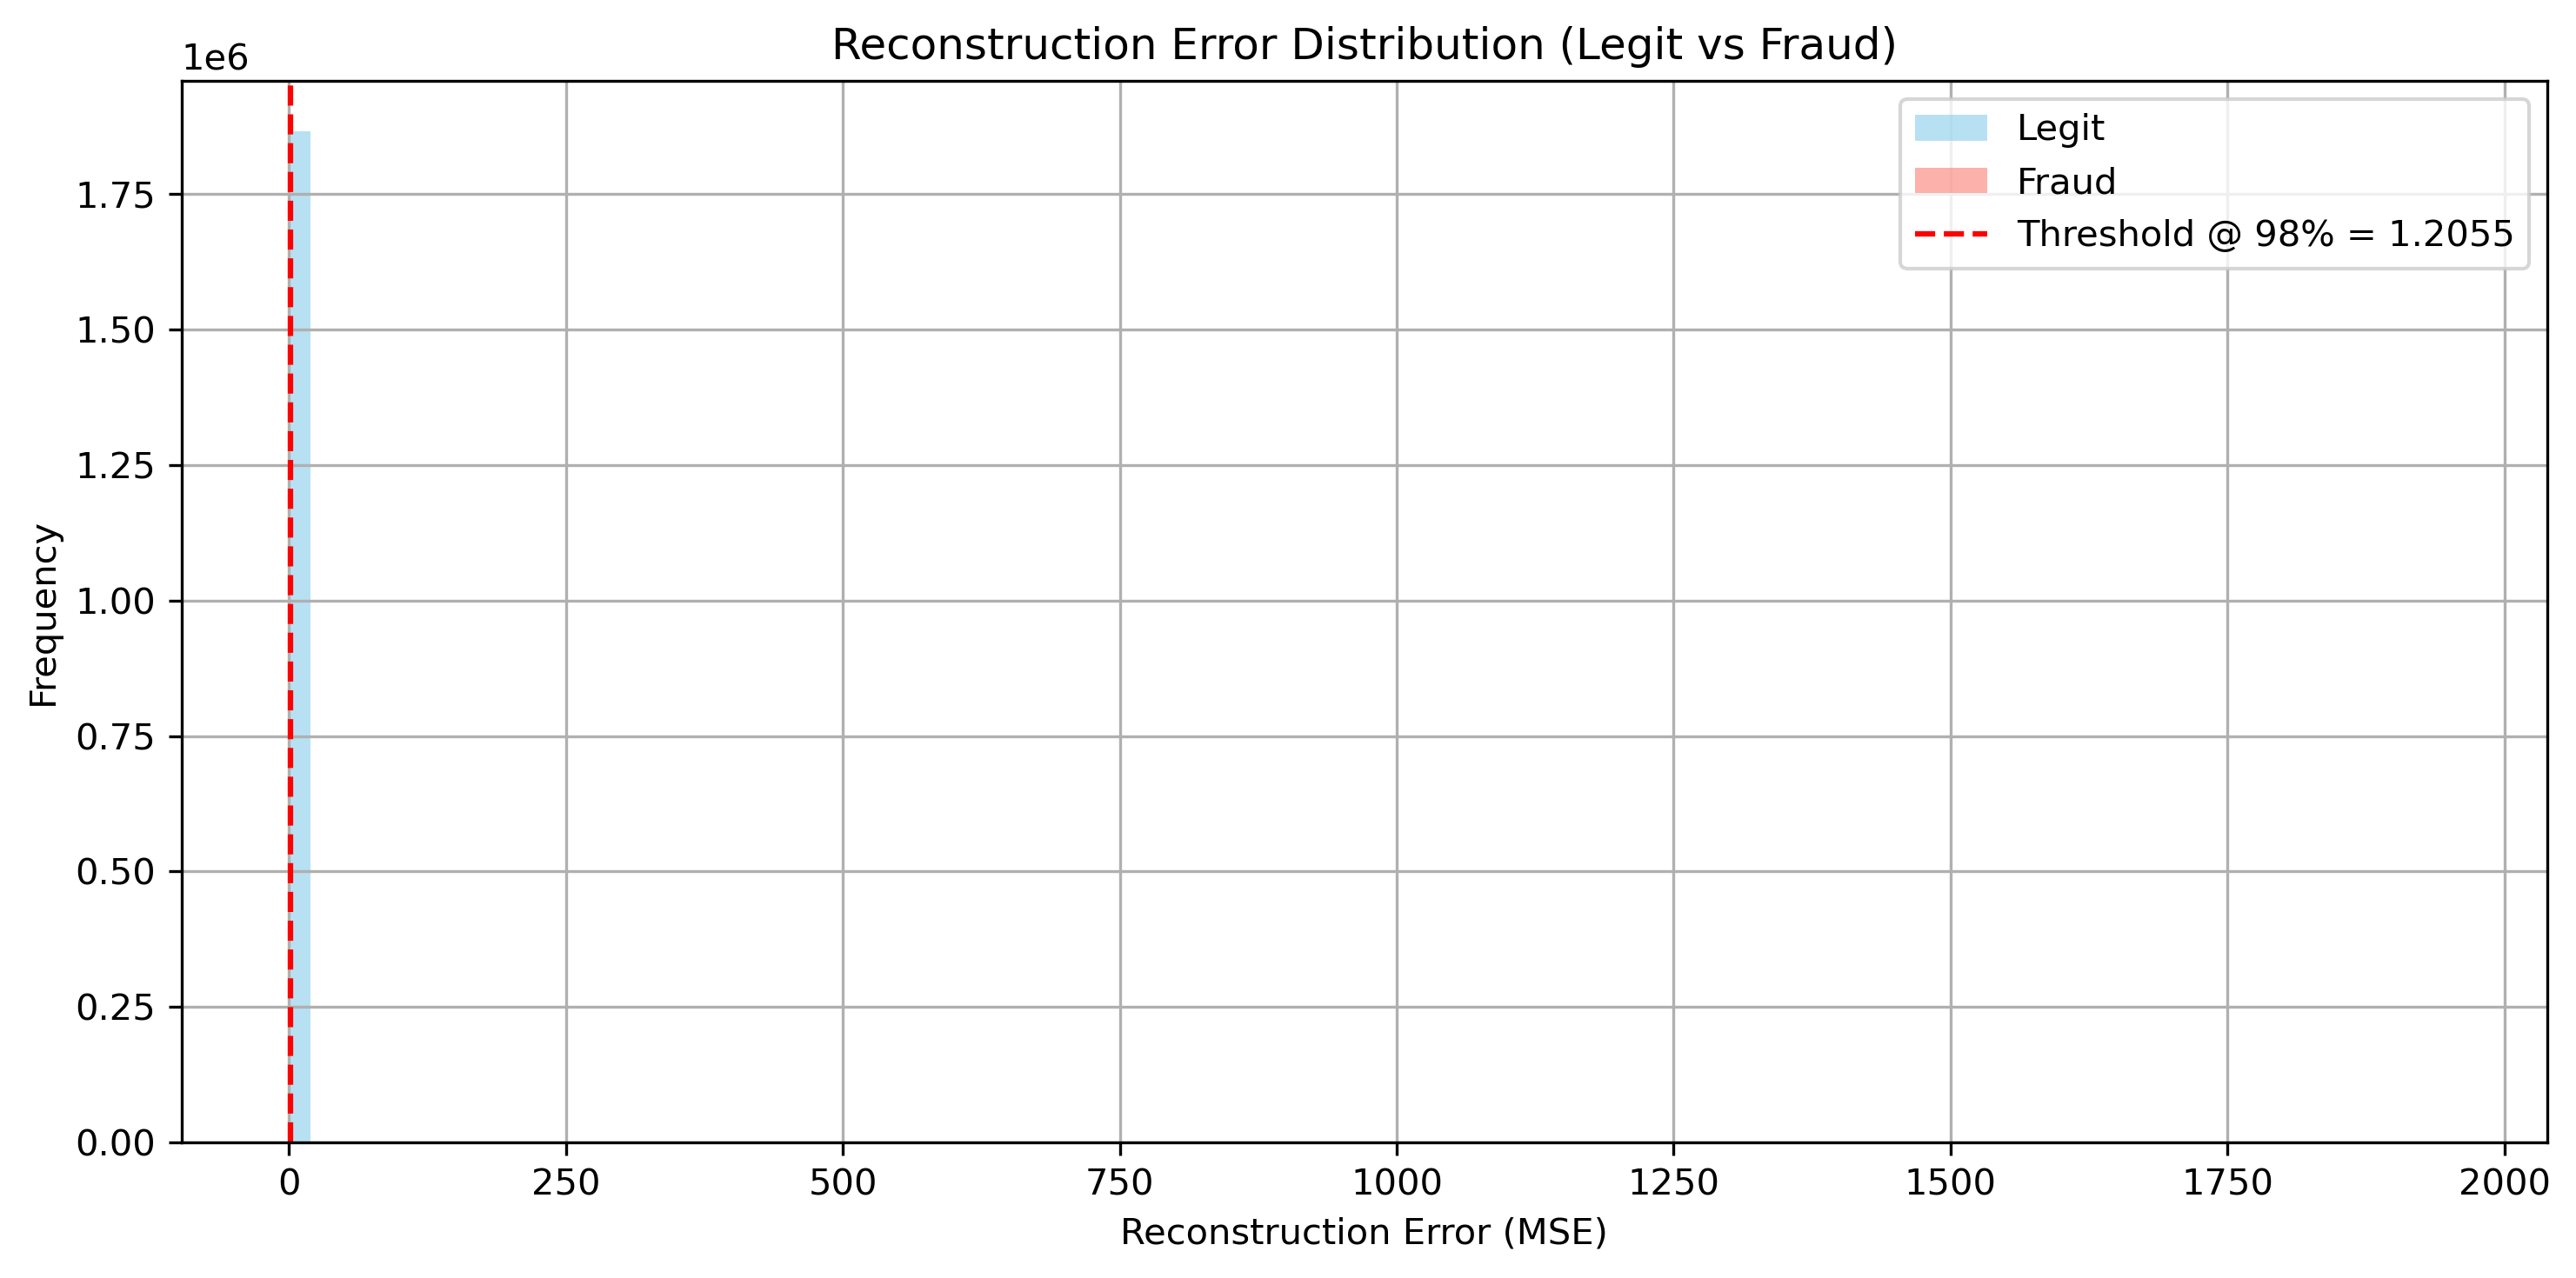

In [10]:
# -------------------------------
# 7. Reconstruction Error Distribution
# -------------------------------
plt.figure(figsize=(10, 5), dpi=300)
plt.hist(mse[y_test == 0], bins=100, alpha=0.6, label='Legit', color='skyblue')
plt.hist(mse[y_test == 1], bins=100, alpha=0.6, label='Fraud', color='salmon')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold @ 98% = {threshold:.4f}')
plt.title("Reconstruction Error Distribution (Legit vs Fraud)")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
